# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [44]:
# TODO
#   df = pd.read_excel(...)
# Load the dataset and set the first column as the index
df = pd.read_excel(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls",
    index_col=0
)

# Display the first few rows
df.head()


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [48]:
# TODO
# Create a new dataframe where missing values are filled with column means
df1 = df.fillna(df.select_dtypes(include=[np.number]).mean())



## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [51]:
# TODO
#   y = ...
# Convert Genotype column to numeric 0/1 labels
_, y = np.unique(df1['Genotype'].values, return_inverse=True)


As predictors, get all but the last four columns of the dataframes.  Store the data matrix into `X` and the names of the columns in `xnames`.

In [52]:
# TODO
#   xnames = ...
#   X = ...

# Get all but the last four columns as predictors
xnames = df1.columns[:-4]
X = df1[xnames].values


Split the data into training and test with 30% allocated for test.  You can use the train

In [53]:
from sklearn.model_selection import train_test_split

# TODO:
#   Xtr, Xts, ytr, yts = ...

# Split the data into training and test sets (30% test size)
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=0)


Scale the data with the `StandardScaler`.  Store the scaled values in `Xtr1` and `Xts1`.

In [56]:
from sklearn.preprocessing import StandardScaler

# TODO
#  Xtr1 = ...
#  Xts1 = ...

# Scale the data using StandardScaler
scaler = StandardScaler()
Xtr1 = scaler.fit_transform(Xtr)
Xts1 = scaler.transform(Xts)


Create a `LogisticRegression` object `logreg` and `fit` on the scaled training data.  Set the regularization level to `C=1e5` and use the optimizer `solver=liblinear`.

In [55]:
# TODO
#   logreg = ...# Train a logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='liblinear')
logreg.fit(Xtr1, ytr)


LogisticRegression(C=100000.0, solver='liblinear')

Measure the accuracy of the classifer on test data.  You should get around 94%.  

In [57]:
# TODO
#   yhat = ...

# Predict the labels for the test set
yhat = logreg.predict(Xts1)

# Measure accuracy
accuracy = np.mean(yhat == yts)
print("Test accuracy:", accuracy)


Test accuracy: 0.9506172839506173


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  Jse the `plt.stem()` function with the `use_line_collection=True` option.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

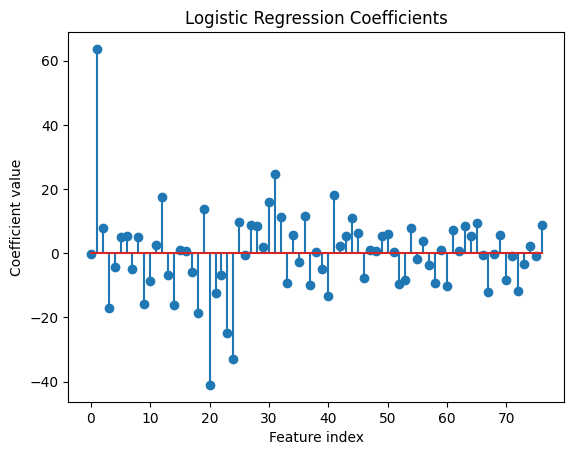

In [60]:
# TODO
#   W = ...
#   plt.stem(...)# Get the logistic regression coefficients
W = logreg.coef_.ravel()   # Flatten to 1D array

# Create a stem plot of the coefficients
plt.stem(W)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.show()

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.   Below we will use L1 regression to enforce sparsity.  Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [64]:
# TODO# Find the indices of the two largest coefficients by absolute value
top_idx = np.argsort(np.abs(W))[-2:]

# Get the corresponding gene (feature) names
top_genes = xnames[top_idx]

print("Top genes with largest |Wi| values:", top_genes)


Top genes with largest |Wi| values: Index(['BRAF_N', 'ITSN1_N'], dtype='object')


## Cross Validation

To obtain a slightly more accurate result, now perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [65]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

# TODO# Perform 10-fold cross validation
precisions, recalls, f1s, errors = [], [], [], []

for train_idx, test_idx in kf.split(X, y):
    # Split data
    Xtr, Xts = X[train_idx], X[test_idx]
    ytr, yts = y[train_idx], y[test_idx]

    # Scale data
    scaler = StandardScaler()
    Xtr1 = scaler.fit_transform(Xtr)
    Xts1 = scaler.transform(Xts)

    # Train logistic regression model
    logreg = LogisticRegression(C=1e5, solver='liblinear')
    logreg.fit(Xtr1, ytr)

    # Predict on test set
    yhat = logreg.predict(Xts1)

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(yts, yhat, average='binary')
    error = np.mean(yhat != yts)

    # Store results
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    errors.append(error)

# Print mean metrics
print("Mean precision:", np.mean(precisions))
print("Mean recall:", np.mean(recalls))
print("Mean F1-score:", np.mean(f1s))
print("Mean error rate:", np.mean(errors))


Mean precision: 0.9542078844296891
Mean recall: 0.9546022875004011
Mean F1-score: 0.954034852266594
Mean error rate: 0.04444444444444444


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [69]:
# TODO
#   y = ...
# Convert the 'class' column to numeric labels 0–7
_, y = np.unique(df1['class'].values, return_inverse=True)
print(np.unique(y))


[0 1 2 3 4 5 6 7]


Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TODO
# Perform 10-fold cross validation and compute confusion matrix and accuracy
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)

nclass = len(np.unique(y))
C = np.zeros((nclass, nclass))
accs = []

for train_idx, test_idx in kf.split(X, y):
    # Split data
    Xtr, Xts = X[train_idx], X[test_idx]
    ytr, yts = y[train_idx], y[test_idx]

    # Scale data
    scaler = StandardScaler()
    Xtr1 = scaler.fit_transform(Xtr)
    Xts1 = scaler.transform(Xts)

    # Train multinomial logistic regression
    logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter=1000)
    logreg.fit(Xtr1, ytr)

    # Predict
    yhat = logreg.predict(Xts1)

    # Compute confusion matrix
    C += confusion_matrix(yts, yhat, labels=np.arange(nclass))

    # Compute accuracy
    accs.append(np.mean(yhat == yts))

# Normalize rows of confusion matrix to sum to 1
C = C / C.sum(axis=1, keepdims=True)

# Print results
print("Normalized confusion matrix:")
print(np.array_str(C, precision=4, suppress_small=True))

print("\nMean accuracy:", np.mean(accs))
print("Standard error:", np.std(accs) / np.sqrt(nfold))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Normalized confusion matrix:
[[0.96   0.02   0.     0.     0.02   0.     0.     0.    ]
 [0.0148 0.9704 0.     0.     0.0074 0.0074 0.     0.    ]
 [0.     0.     0.9933 0.0067 0.     0.     0.     0.    ]
 [0.0074 0.     0.     0.9852 0.     0.     0.0074 0.    ]
 [0.     0.0148 0.     0.     0.9852 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.0074 0.     0.     0.     0.9926 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]

Mean accuracy: 0.9851851851851852
Standard error: 0.003971779738801339


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

Coefficient matrix shape: (8, 77)


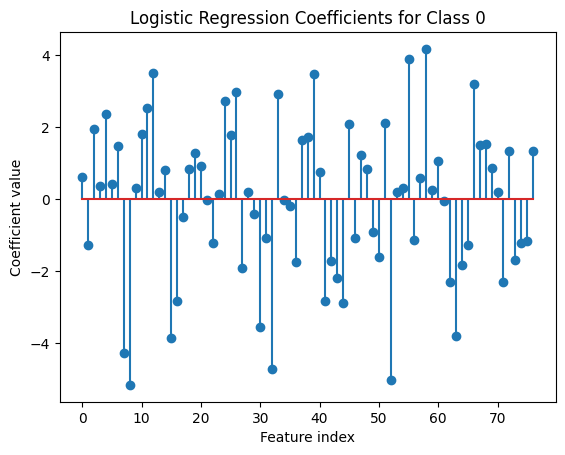

In [71]:
# TODO# Re-train logistic regression on the full dataset
scaler = StandardScaler()
X1 = scaler.fit_transform(X)

logreg = LogisticRegression(C=1e5, solver='lbfgs', max_iter=1000)
logreg.fit(X1, y)

# Get the weight coefficients (8 x 77 matrix)
W = logreg.coef_
print("Coefficient matrix shape:", W.shape)

# Plot the coefficients for the first class
plt.stem(W[0])
plt.title("Logistic Regression Coefficients for Class 0")
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.show()



## L1-Regularization

This section is bonus.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [housing demo](../unit05_lasso/demo2_housing.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

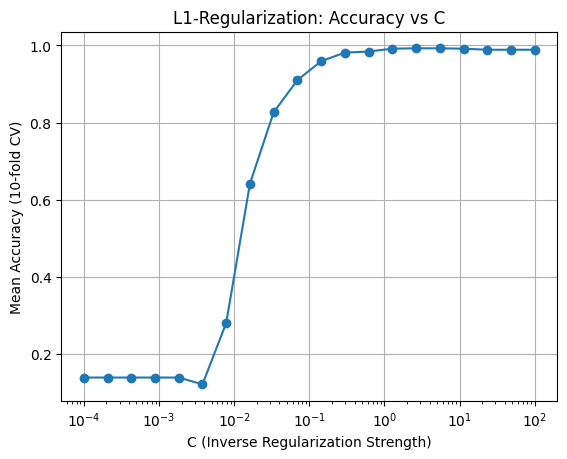

Best C = 2.6366508987303554
Best mean accuracy = 0.9925925925925926


In [73]:
# TODO
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Standardize the data
scaler = StandardScaler()
X1 = scaler.fit_transform(X)

# Define range of C values (inverse regularization strength)
C_values = np.logspace(-4, 2, 20)  # 20 values between 1e-4 and 1e2

nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)

mean_accs = []

# Perform 10-fold cross-validation for each C
for C in C_values:
    accs = []
    for train_idx, test_idx in kf.split(X1, y):
        Xtr, Xts = X1[train_idx], X1[test_idx]
        ytr, yts = y[train_idx], y[test_idx]

        # L1 regularized logistic regression
        logreg = LogisticRegression(
            penalty='l1', solver='liblinear', C=C, max_iter=1000
        )
        logreg.fit(Xtr, ytr)
        yhat = logreg.predict(Xts)
        accs.append(np.mean(yhat == yts))

    mean_accs.append(np.mean(accs))

# Plot mean accuracy vs C
plt.semilogx(C_values, mean_accs, marker='o')
plt.title("L1-Regularization: Accuracy vs C")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Mean Accuracy (10-fold CV)")
plt.grid(True)
plt.show()

# Print best C and accuracy
best_idx = np.argmax(mean_accs)
print("Best C =", C_values[best_idx])
print("Best mean accuracy =", mean_accs[best_idx])
